## POS tagging using modified Viterbi

### Data Preparation

In [110]:
#Importing libraries
import nltk
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\akcanup\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\akcanup\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [111]:
# Reading the Treebank tagged sentences
bank_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [112]:
bank_data[:4]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [113]:
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [114]:
#setting the random seed
random.seed(1234)

#Dividing the data into train and test sets
train_set, test_set = train_test_split(bank_data,train_size=0.95)

#Fetching the length of training and test sets
print(len(train_set))
print(len(test_set))

3718
196


In [115]:
# Getting list of tagged words in train set
train_tagged_words = [word for sent in train_set for word in sent]
#Getting the length of the total tagged words in train set
len(train_tagged_words)

95495

In [116]:
# Viewing the first 12 tokens in the train set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:12]

['Mr.',
 'Rowe',
 'also',
 'noted',
 'that',
 'political',
 'concerns',
 'also',
 'worried',
 'New',
 'England',
 'Electric']

In [117]:
# Getting the total unique words in the train set
V = set(tokens)
print(len(V))

12048


In [118]:
# Number of POS tags in the train-corpus
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'ADP', 'NOUN', 'PRT', 'X', 'DET', 'ADV', 'NUM', 'ADJ', 'CONJ', '.', 'PRON', 'VERB'}


### Build the vanilla Viterbi based POS tagger

In [119]:
#Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [120]:
# Creating numpy array of no of POS tags
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [121]:
# Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [122]:
#Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [123]:
# Creating t x t (pos tags x pos tags)transition matrix of tags
# Each column is t2, each row is t1
# Thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [124]:
# Converting the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,ADP,NOUN,PRT,X,DET,ADV,NUM,ADJ,CONJ,.,PRON,VERB
ADP,0.017334,0.323133,0.001498,0.035309,0.322277,0.013268,0.063236,0.106570,0.000856,0.039910,0.068264,0.008346
NOUN,0.176481,0.264028,0.043226,0.029426,0.013654,0.017049,0.009529,0.012413,0.042715,0.240261,0.004783,0.146435
PRT,0.019136,0.245464,0.001980,0.013197,0.102606,0.010558,0.057077,0.084790,0.002309,0.044540,0.016826,0.401518
X,0.144808,0.062083,0.183074,0.075580,0.053985,0.026199,0.002699,0.016354,0.010162,0.164179,0.055573,0.205303
DET,0.009310,0.638980,0.000242,0.045702,0.005803,0.012574,0.021521,0.204570,0.000484,0.017410,0.003748,0.039657
ADV,0.121644,0.031820,0.014253,0.022870,0.068280,0.080875,0.031820,0.129267,0.007292,0.136228,0.015247,0.340404
NUM,0.034513,0.352507,0.027434,0.212094,0.002655,0.002950,0.186726,0.032448,0.013274,0.115929,0.001475,0.017994
ADJ,0.078464,0.700050,0.010429,0.020857,0.004966,0.004966,0.021023,0.065387,0.016222,0.065221,0.000662,0.011753
CONJ,0.054858,0.351000,0.003719,0.008368,0.119014,0.054858,0.040911,0.116690,0.000465,0.035797,0.058113,0.156206
.,0.089946,0.223070,0.002424,0.027020,0.172801,0.052603,0.081777,0.043716,0.058169,0.093716,0.066158,0.088510


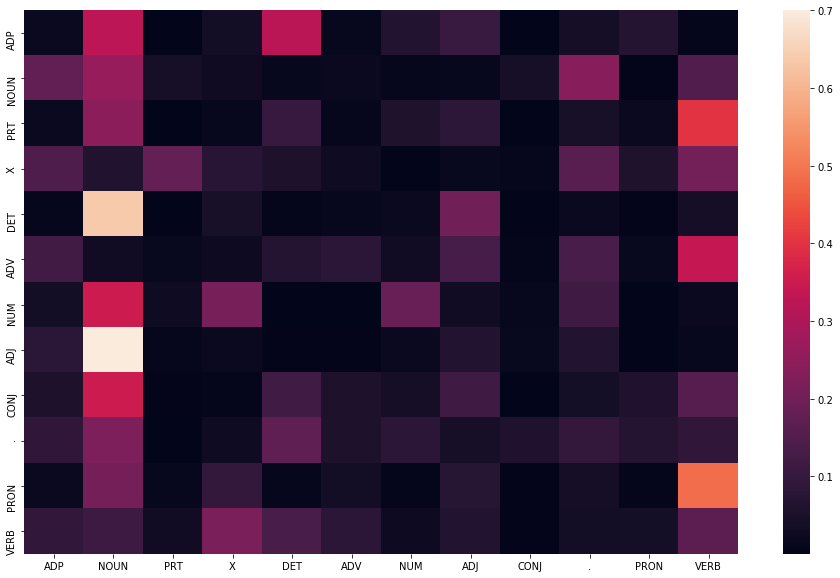

In [125]:
# Heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(16, 10))
sns.heatmap(tags_df)
plt.show()

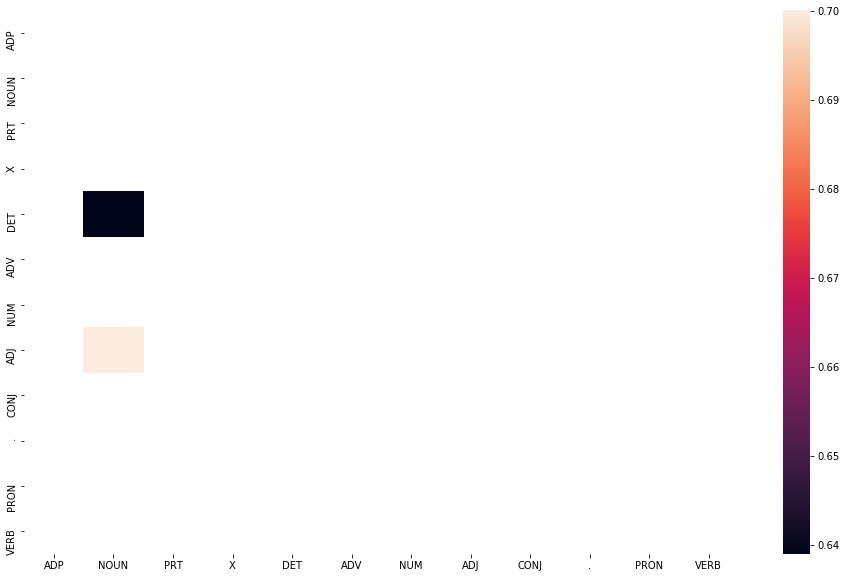

In [126]:
# Frequent tags
# Filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(16, 10))
sns.heatmap(tags_frequent)
plt.show()

In [127]:
#Getting the total length of tagged words in training corpus
len(train_tagged_words)

95495

In [128]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #Initialising the list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [129]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset
# list of tagged words in test set
test_run_base = [tup for sent in test_set for tup in sent]

# list of  words which are untagged in test set
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [130]:
# Tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [131]:
#Printing total time taken to train the algorithm
print(difference)

846.4171085357666


In [132]:
# Getting accuracy of model
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print(accuracy)

0.9044585987261147


In [133]:
import codecs

In [134]:
#Reading the text file
lines=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in f:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

### Solve the problem of unknown words

In [135]:
lines

['Android is a mobile operating system developed by Google.\r\n',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.\r\n',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.\r\n",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.\r\n',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.\r\n',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.\r\n',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.\r\n',
 'Show me the cheapest round trips from Dallas to Atlanta\r\n',
 'I would like to see flights from Denver to Philadelphia.\r\n',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.\r\n',
 'NASA

In [136]:
#Stripping the special characters and empty strings in the list file
test_lines =[sent.rstrip() for sent in lines if sent.rstrip()!='']
test_lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

In [137]:
#Getting the words in the test set which are incorrectly classified
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('and', 'CONJ'), (('prosecuted', 'ADP'), ('prosecuted', 'VERB'))],
 [('law', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('The', 'DET'), (('Contra', 'ADP'), ('Contra', 'NOUN'))],
 [('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', 'ADP'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', 'ADP'), ('Sandinista', 'NOUN'))],
 [('major', 'ADJ'), (('offensive', 'ADP'), ('offensive', 'NOUN'))],
 [('the', 'DET'), (('rebel', 'ADP'), ('rebel', 'NOUN'))],
 [('was', 'VERB'), (('untrained', 'ADP'), ('untrained', 'ADJ'))],
 [('one', 'NUM'), (('botched', 'ADP'), ('botched', 'ADJ'))],
 [('a', 'DET'), (('wheel-loader', 'ADP'), ('wheel-loader', 'ADJ'))],
 [('in', 'ADP'), (('Heidelberg', 'ADP'), ('Heidelberg', 'NOUN'))],
 [('``', '.'), (('vague', 'ADP'), ('vague', 'ADJ'))],
 [('and', 'CONJ'), (('mushy', 'ADP'), ('mushy', 'ADJ'))],
 [("''", '.'), (('that', 'DET'), ('that', 'ADP'))],
 [('all', 'DET'), (('viewpoints', 'ADP'), ('viewpoints', 'NOUN'))

In [138]:
#Importing Libraries
import requests
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\akcanup\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [139]:
#Getting the predictions on the test sentences
sample_pred_list =[]
for line in test_lines:
    sample_pred_list=sample_pred_list+list(Viterbi(word_tokenize(line)))
sample_pred_list

[('Android', 'ADP'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'ADP'),
 ('.', '.'),
 ('Android', 'ADP'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'ADP'),
 ('worldwide', 'ADP'),
 ('on', 'ADP'),
 ('smartphones', 'ADP'),
 ('since', 'ADP'),
 ('2011', 'ADP'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'ADP'),
 ('.', '.'),
 ('Google', 'ADP'),
 ('and', 'CONJ'),
 ('Twitter', 'ADP'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'ADP'),
 ('that', 'DET'),
 ('gave', 'VERB'),
 ('Google', 'ADP'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'ADP'),
 ("'s", 'PRT'),
 ('firehose', 'ADP'),
 ('.', '.'),
 ('Twitter', 'ADP'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'ADP'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOU

In [140]:
#Getting the tokens in the test file
sample_words=[tokens for line in test_lines for tokens in word_tokenize(line)]

In [141]:
#Getting the list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(sample_words) - set(tokens))
words_not_in_corpus

['Cup',
 'tweets',
 'tournament',
 'worldwide',
 'contested',
 'invited',
 'interact',
 'arriving',
 '2013',
 'domineering',
 '2011',
 '21st',
 '2015',
 'firehose',
 'online',
 'NASA',
 'smartphones',
 'FIFA',
 '2018',
 'Satellite',
 'OS',
 'cheapest',
 'Android',
 'messages',
 'Twitter',
 'Google',
 'ICESAT-2',
 'personality',
 'trips']

In [142]:
#Getting the tags predicted for unknown words
[tup for tup in sample_pred_list for word in words_not_in_corpus if tup[0]==word ]

[('Android', 'ADP'),
 ('Google', 'ADP'),
 ('Android', 'ADP'),
 ('OS', 'ADP'),
 ('worldwide', 'ADP'),
 ('smartphones', 'ADP'),
 ('2011', 'ADP'),
 ('2013', 'ADP'),
 ('Google', 'ADP'),
 ('Twitter', 'ADP'),
 ('2015', 'ADP'),
 ('Google', 'ADP'),
 ('Twitter', 'ADP'),
 ('firehose', 'ADP'),
 ('Twitter', 'ADP'),
 ('online', 'ADP'),
 ('interact', 'ADP'),
 ('messages', 'ADP'),
 ('tweets', 'ADP'),
 ('domineering', 'ADP'),
 ('personality', 'ADP'),
 ('2018', 'ADP'),
 ('FIFA', 'ADP'),
 ('Cup', 'ADP'),
 ('21st', 'ADP'),
 ('FIFA', 'ADP'),
 ('Cup', 'ADP'),
 ('tournament', 'ADP'),
 ('contested', 'ADP'),
 ('Cup', 'ADP'),
 ('cheapest', 'ADP'),
 ('trips', 'ADP'),
 ('arriving', 'ADP'),
 ('NASA', 'ADP'),
 ('invited', 'ADP'),
 ('ICESAT-2', 'ADP'),
 ('Satellite', 'ADP')]

In [143]:
#seeing the count of all tags in the training set
from collections import Counter
tag_counts = Counter(pair[1] for pair in train_tagged_words)
tag_counts

Counter({'NOUN': 27391,
         'ADV': 3017,
         'VERB': 12822,
         'ADP': 9346,
         'ADJ': 6041,
         '.': 11140,
         'DET': 8271,
         'X': 6298,
         'PRT': 3031,
         'PRON': 2597,
         'CONJ': 2151,
         'NUM': 3390})

In [144]:
#seeing most common tags can in the training corpus
tag_counts.most_common(5)

[('NOUN', 27391), ('VERB', 12822), ('.', 11140), ('ADP', 9346), ('DET', 8271)]

In [145]:
#seeing the count of incorrectly classfied words for each tag
wrong_tag_counts = Counter(pair[1][0][1] for pair in incorrect_tagged_cases)
wrong_tag_counts

Counter({'ADP': 388,
         'VERB': 17,
         'DET': 11,
         'PRT': 7,
         'ADV': 14,
         'ADJ': 25,
         'NOUN': 26,
         '.': 1,
         'NUM': 4,
         'PRON': 1,
         'CONJ': 1})

In [146]:
# seeing the percentage of verbs which are classifed as 'verb which end with 'ed'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in verbs if pair[0].endswith('ed')]
print(len(ed_verbs) / len(verbs))
ed_verbs[:20]

0.20620807986273593


[('noted', 'VERB'),
 ('worried', 'VERB'),
 ('received', 'VERB'),
 ('amounted', 'VERB'),
 ('consented', 'VERB'),
 ('discovered', 'VERB'),
 ('bolstered', 'VERB'),
 ('continued', 'VERB'),
 ('feed', 'VERB'),
 ('announced', 'VERB'),
 ('sweetened', 'VERB'),
 ('rusted', 'VERB'),
 ('showed', 'VERB'),
 ('dropped', 'VERB'),
 ('need', 'VERB'),
 ('based', 'VERB'),
 ('helped', 'VERB'),
 ('cited', 'VERB'),
 ('proposed', 'VERB'),
 ('proposed', 'VERB')]

In [147]:
# seeing the percentage of verbs which are classifed as 'verb which end with 'ing'
verbs = [pair for pair in train_tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in verbs if pair[0].endswith('ing')]
print(len(ing_verbs) / len(verbs))
ing_verbs[:20]

0.10895336141007643


[('admitting', 'VERB'),
 ('denying', 'VERB'),
 ('including', 'VERB'),
 ('trying', 'VERB'),
 ('affecting', 'VERB'),
 ('cutting', 'VERB'),
 ('suing', 'VERB'),
 ('falling', 'VERB'),
 ('exchanging', 'VERB'),
 ('slowing', 'VERB'),
 ('signaling', 'VERB'),
 ('stressing', 'VERB'),
 ('lying', 'VERB'),
 ('turning', 'VERB'),
 ('moving', 'VERB'),
 ('according', 'VERB'),
 ('increasing', 'VERB'),
 ('bring', 'VERB'),
 ('bring', 'VERB'),
 ('discontinuing', 'VERB')]

In [148]:
#seeing percentage of Adjective tags followed by nouns
# create a list of all tags (without the words)
tags = [pair[1] for pair in train_tagged_words]

# create a list of Adj tags
adj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, Noun) tags
adj_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print(len(adj_tags))
print(len(adj_noun_tags))
print(len(adj_noun_tags) / len(adj_tags))

6041
4229
0.7000496606522099


In [149]:
#seeing the percentage of Determinent tags followed by nouns
dt_tags = [t for t in tags if t == 'DET']
dt_noun_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print(len(dt_tags))
print(len(dt_noun_tags))
print(len(dt_noun_tags) / len(dt_tags))

8271
5285
0.6389795671623746


In [150]:
#percentage of Adverbs tags followed by Verbs
adv_tags = [t for t in tags if t == 'ADV']
adv_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADV' and tags[index+1]=='VERB']

print(len(adv_tags))
print(len(adv_vb_tags))
print(len(adv_vb_tags) / len(adv_tags))

3017
1027
0.34040437520715944


In [151]:
# specifying patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense verbs
    (r'.*es$', 'VERB'),               # singular present verbs
    (r'.*ould$', 'VERB'),              # modal verbs
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'),   # articles or determinants
    (r'.*able$', 'ADJ'),                # adjectives
    (r'.*ness$', 'NOUN'),                # nouns formed from adjectives
    (r'.*ly$', 'ADV'),                  # adverbs
    (r'.*', 'NOUN')                    # nouns
]

In [152]:
# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

lexicon_tagger.evaluate(test_set)

0.9471144566685968

#### Evaluating tagging accuracy

In [153]:
#Trigram tagger backed by Bigram backed by Unigram which is backed by rule based tagger
t0 = nltk.RegexpTagger(patterns)
t1 = nltk.UnigramTagger(train_set, backoff=t0)
t2 = nltk.BigramTagger(train_set, backoff=t1)
t3 = nltk.TrigramTagger(train_set, backoff=t2)

In [154]:
#Importing libraries for brill
import nltk.tag
from nltk.tag import brill
from nltk.tag.brill import *
from nltk.tbl.template import Template
from nltk.tag import BrillTaggerTrainer

#Clear existing templates if any
Template._cleartemplates()

#Load the fntbl37 template
templates = fntbl37()
 
#Train the Brill model
trainer = BrillTaggerTrainer(t3, templates)
brill_tagger = trainer.train(train_set, max_rules=100, min_score=3)

In [155]:
# Viterbi Heuristic
def Viterbi_updated(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax==0.0):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [156]:
# Tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

830.9402914047241


In [157]:
# Calculating the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.9498166377147269

### The accuracy has come out to be 95.1%

### Listing down cases which were incorrectly tagged by original POS tagger and which got corrected by our modifications

In [158]:
#Printing the test lines with the initial Viterbi algorithm
for line in test_lines:
    print(list(Viterbi(word_tokenize(line))))

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')]
[('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.')]
[('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose', 'ADP'), ('.', '.')]
[('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', '

In [159]:
#Printing the test lines with the updated Viterbi algorithm
for line in test_lines:
    print(list(Viterbi_updated(word_tokenize(line))))

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]
[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET')

In [160]:
# Viterbi Heuristic
def Viterbi_updated2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
       
        #Check if state probability is zero
        if(pmax<0.001):
            #If state probability is zero i.e if the word is unknown if updates the tag based on the brill tagger
            state_max = brill_tagger.tag([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [161]:
# Tagging the test sentences with the updated Viterbi algorithm
start = time.time()
updated_tagged_seq = Viterbi_updated2(test_tagged_words)
end = time.time()
difference = end-start
#Print total time taken to train the algorithm
print(difference)

813.2899222373962


In [162]:
# Calculating the accuracy for the updated Viterbi algorithm
check = [i for i, j in zip(updated_tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(updated_tagged_seq)
accuracy

0.9457633661455318

### The accuracy has come out to be 94.6% i.e it's increased